In [72]:
import os
import time
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import confusion_matrix

import torch
import torchvision
from torchvision import transforms, models, datasets

from torch.utils.data import Dataset, random_split
from torch.optim import lr_scheduler

torch.Size([3, 200, 200])


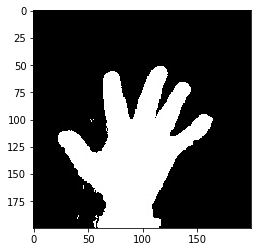

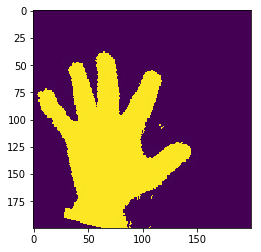

In [73]:
img = Image.open('gesture_data/five_fingers/2020-01-12-13-45-53.772685.jpg')

data_transform = transforms.Compose([
    transforms.RandomAffine(25,
                            (0.15, 0.15),
                            (0.7, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

img_tr = data_transform(img)
print(img_tr.shape)
plt.imshow(img)
plt.show()
plt.imshow(img_tr[0])

In [74]:
torch.cuda.is_available()

True

In [75]:
!ls gesture_data/

fist	      four_fingers  ok		three_fingers
five_fingers  noise	    one_finger	two_fingers


In [76]:
gestures_dict = ('fist', 'five_fingers', 'four_fingers', 'noise', 'ok', 'one_finger', 'three_fingers', 'two_fingers')

In [77]:
len(glob('gesture_data/*/*'))

926

In [78]:
for dirr in glob('gesture_data/*'):
    print(dirr, len(glob(dirr+"/*")))

gesture_data/three_fingers 225
gesture_data/two_fingers 97
gesture_data/five_fingers 99
gesture_data/ok 102
gesture_data/fist 100
gesture_data/noise 102
gesture_data/four_fingers 103
gesture_data/one_finger 98


In [79]:
batch_size=32

In [80]:
data_transform = transforms.Compose([
        transforms.RandomAffine(25, 
                                (0.15, 0.15),
                                (0.7, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

gestures_dataset = datasets.ImageFolder(root='gesture_data',
                                           transform=data_transform)

four_fingers


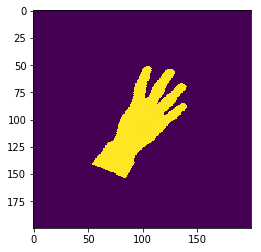

----------------------------------
five_fingers


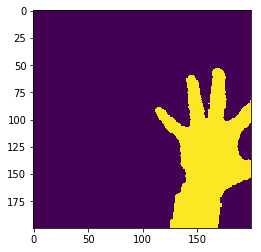

----------------------------------
noise


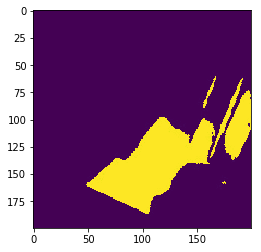

----------------------------------
three_fingers


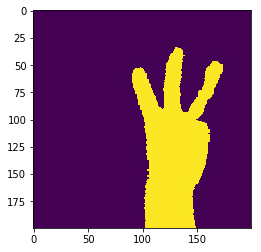

----------------------------------
three_fingers


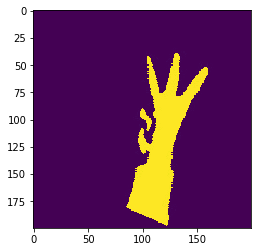

----------------------------------
three_fingers


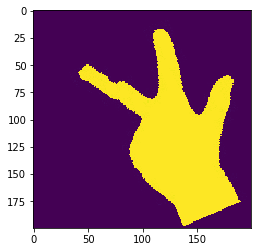

----------------------------------
noise


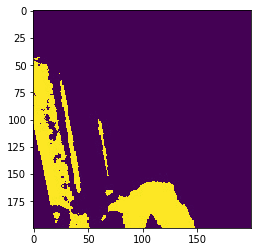

----------------------------------
ok


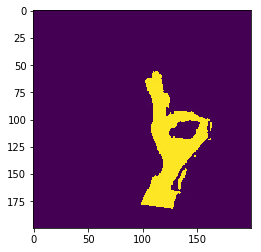

----------------------------------
four_fingers


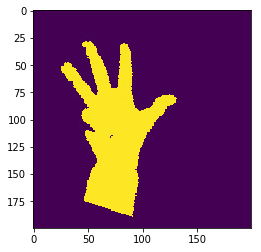

----------------------------------
four_fingers


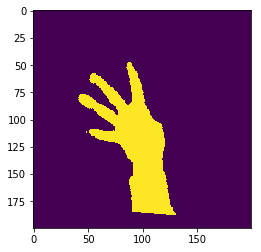

----------------------------------


In [81]:
for i in np.random.randint(0, 808, 10):
    print(gestures_dict[gestures_dataset[i][1]])
    plt.imshow(gestures_dataset[i][0][0])
    plt.show()
    print('----------------------------------')

In [82]:
dataset_length = len(gestures_dataset)

val_size = .2
val_length = int(dataset_length * val_size)

train_data_raw, val_data_raw = random_split(gestures_dataset, [dataset_length - val_length, val_length])

assert isinstance(train_data_raw, torch.utils.data.Dataset)
assert isinstance(val_data_raw, torch.utils.data.Dataset)

In [83]:
train_loader = torch.utils.data.DataLoader(train_data_raw, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_data_raw, batch_size=batch_size, shuffle=True, num_workers=8)

In [84]:
len(train_loader)

24

In [85]:
num_classes = 8

model = torchvision.models.resnet18(pretrained=True)
model.fc = torch.nn.Linear(512, num_classes)
model.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8, patience=2, )

In [86]:
valid_loss_min = np.Inf
patience = 5
n_epochs = 200

#early_stopping_counter
es_counter = 0

stop = False

for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)

    train_loss = []
    train_auc = []

    for batch_i, sample_batch in enumerate(train_loader):
        
        #print(sample_batch)
        
        data, target = sample_batch[0].cuda(), sample_batch[1].cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        train_loss.append(loss.item())
        #NEVER WRITE LIKE THIS!!!
        #train_loss.append(loss)
        
        loss.backward()
        optimizer.step()
    
    model.eval()
    val_loss = []
    pred_num = 0
    
    for batch_i, sample_batch in enumerate(val_loader):
        
        data, target = sample_batch[0].cuda(), sample_batch[1].cuda()
        
        #print(data.shape)
        output = model(data)

        loss = criterion(output, target)

        val_loss.append(loss.item()) 
        
        _, predicted = torch.max(output, 1)
        pred_num += (target==predicted).sum()
        
        

    print(f'Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, val accuracy: {int(pred_num)/val_length}')
    
    valid_loss = np.mean(val_loss)
    scheduler.step(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model_56.pth')
        valid_loss_min = valid_loss
        p = 0

    if valid_loss > valid_loss_min:
        p += 1
        print(f'{p} epochs of increasing val loss')
        if p > patience:
            print('Stopping training')
            stop = True
            break        
            
    if stop:
        break

Mon Jan 13 16:58:24 2020 Epoch: 1
Epoch 1, train loss: 1.4629, valid loss: 0.9853, val accuracy: 0.7189189189189189
Validation loss decreased (inf --> 0.985337).  Saving model ...
Mon Jan 13 16:58:26 2020 Epoch: 2
Epoch 2, train loss: 0.6934, valid loss: 0.6365, val accuracy: 0.8108108108108109
Validation loss decreased (0.985337 --> 0.636474).  Saving model ...
Mon Jan 13 16:58:29 2020 Epoch: 3
Epoch 3, train loss: 0.5804, valid loss: 0.5103, val accuracy: 0.8162162162162162
Validation loss decreased (0.636474 --> 0.510298).  Saving model ...
Mon Jan 13 16:58:32 2020 Epoch: 4
Epoch 4, train loss: 0.4688, valid loss: 0.4558, val accuracy: 0.8162162162162162
Validation loss decreased (0.510298 --> 0.455821).  Saving model ...
Mon Jan 13 16:58:35 2020 Epoch: 5
Epoch 5, train loss: 0.3133, valid loss: 0.2766, val accuracy: 0.9081081081081082
Validation loss decreased (0.455821 --> 0.276624).  Saving model ...
Mon Jan 13 16:58:38 2020 Epoch: 6
Epoch 6, train loss: 0.2387, valid loss: 0.516

In [88]:
PATH = './best_model_56.pth'
#torch.save(model.state_dict(), PATH)

In [89]:
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(512, num_classes)
model.load_state_dict(torch.load(PATH))
model.cuda()
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [90]:
len(val_loader)

6

In [93]:
model.eval()
pred_num = 0

labels_all = []
preds_all = []

inputs_wrong = []
labels_wrong = []
pred_wrong = []

l = 0

time_start = time.time()
for val_batch in val_loader:
    
    inputs, labels = val_batch[0].cuda(), val_batch[1].cuda()
    l += len(labels)
    
    labels_all += [int(i) for i in labels]
    
    outputs = model(inputs)
    
    _, predicted = torch.max(outputs, 1)
    
    preds_all += [int(i) for i in predicted]
    pred_num += (labels==predicted).sum()
    inputs_wrong.append(inputs[labels!=predicted])
    labels_wrong.append(labels[labels!=predicted])
    pred_wrong.append(predicted[labels!=predicted])

time_end = time.time()

In [94]:
print("Validation time: {:.2f}".format(time_end - time_start))
print("Accuracy: {:.4f}". format(int(pred_num)/val_length))

Validation time: 0.71
Accuracy: 0.9243


In [95]:
labels_wrong

[tensor([6, 3, 1], device='cuda:0'),
 tensor([4], device='cuda:0'),
 tensor([4, 3], device='cuda:0'),
 tensor([1, 4], device='cuda:0'),
 tensor([3, 5, 7, 3], device='cuda:0'),
 tensor([1, 4], device='cuda:0')]

true: 6, predicted: 2


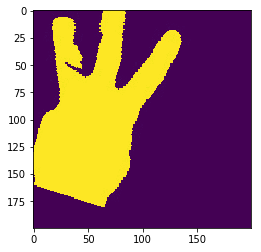

true: 3, predicted: 4


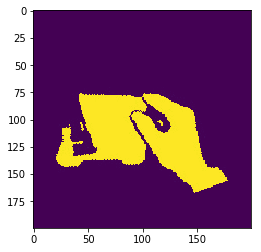

true: 1, predicted: 2


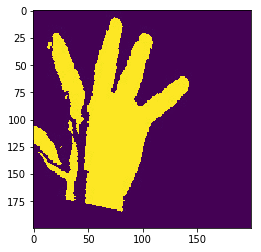

true: 4, predicted: 3


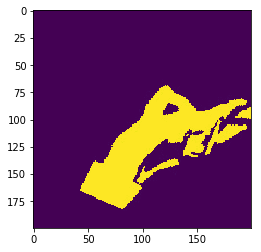

true: 4, predicted: 5


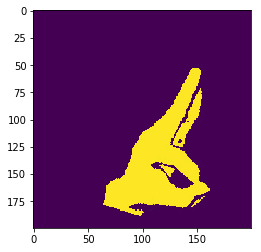

true: 3, predicted: 5


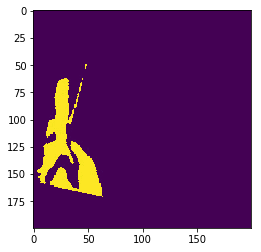

true: 1, predicted: 2


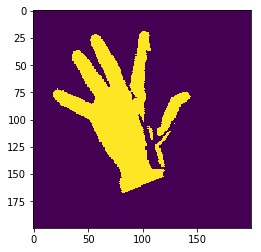

true: 4, predicted: 3


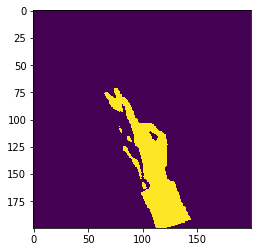

true: 3, predicted: 4


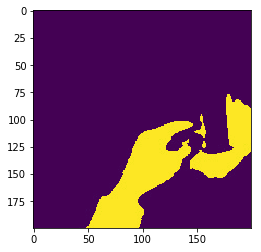

true: 5, predicted: 0


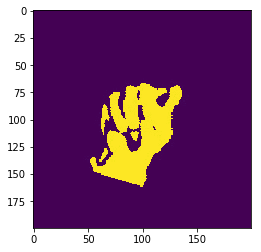

true: 7, predicted: 5


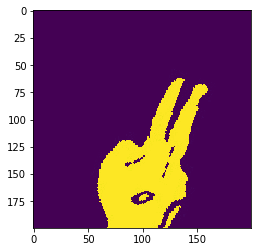

true: 3, predicted: 0


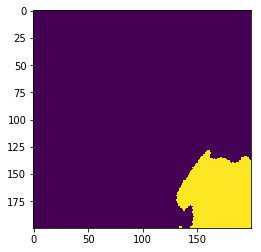

true: 1, predicted: 2


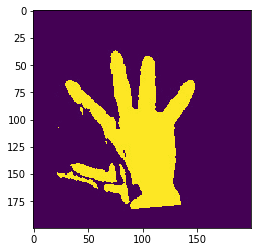

true: 4, predicted: 6


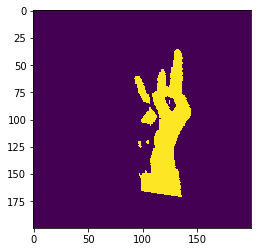

In [96]:
for i in range(len(inputs_wrong)):
    for j in range(len(inputs_wrong[i])):
        print('true: {}, predicted: {}'.format(labels_wrong[i][j], pred_wrong[i][j]))
        plt.imshow(np.array(inputs_wrong[i][j][0].cpu()))
        plt.show()

In [ ]:
gestures_dict = ('fist', 'five_fingers', 'four_fingers', 'noise', 'ok', 'one_finger', 'three_fingers', 'two_fingers')

In [60]:
preds_all[:5], labels_all[:5]

([6, 7, 6, 6, 2], [6, 7, 6, 2, 2])

In [33]:
cm = confusion_matrix(labels_all, preds_all)
for i in range(8):
    cm[i,i] = 0

In [34]:
import seaborn as sns

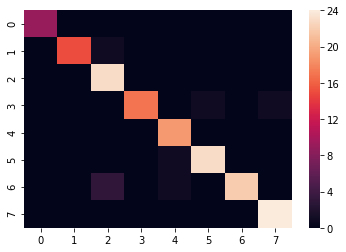

In [35]:
sns.heatmap(confusion_matrix(labels_all, preds_all))